### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [115]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [116]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [117]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [127]:
# Functions for Optuna NNs

def create_snnn_model_hyperpars(neurons_base=4, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn


def objective_nn(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]


(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 60.30287837982178
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-08 00:32:31,669] A new study created in memory with name: no-name-7df3654e-446f-4691-80bc-c1831cbf1c4d
[I 2022-09-08 00:32:32,415] Trial 0 finished with value: -0.0006937496290459367 and parameters: {'n_estimators': 1028, 'max_depth': 4, 'learning_rate': 0.02699011107483833, 'colsample_bytree': 0.1434637678114848, 'subsample': 0.8416246827837442, 'alpha': 26.544105177284095, 'lambda': 2.3344504570989324, 'gamma': 1.8360398890458147e-08, 'min_child_weight': 0.7629601550104832}. Best is trial 0 with value: -0.0006937496290459367.
[I 2022-09-08 00:32:32,979] Trial 1 finished with value: -0.0008618486821787119 and parameters: {'n_estimators': 1198, 'max_depth': 3, 'learning_rate': 0.002869775417295634, 'colsample_bytree': 0.13717124391392177, 'subsample': 0.48841162720656695, 'alpha': 4.113555797740611, 'lambda': 0.5001316638620837, 'gamma': 1.2641870424489507e-06, 'min_child_weight': 0.5291718243766121}. Best is trial 0 with value: -0.0006937496290459367.
[I 2022-09-08 00:32:33

Total time for hypermarameter optimization  12.983632802963257
        n_estimators : 1305
           max_depth : 3
       learning_rate : 0.007047982490408479
    colsample_bytree : 0.05131026026732624
           subsample : 0.25924049137486027
               alpha : 10.355889063943998
              lambda : 4.848867870357538
               gamma : 5.4202476545238434e-08
    min_child_weight : 0.4010631965084693
best objective value : 2.6425668969909367e-05
Optuna XGB train: 
 8.272898696680256 0.04860683057515025 
validation 
 7.749183538614853 0.003979949372518332 9.152992960537524 0.01254148561349111 
test 
 7.830425943156896 0.018537910000074986
3801
Minimum Validation Loss: 120.1856
3025
Minimum Validation Loss: 119.3560
3457
Minimum Validation Loss: 119.3280


[I 2022-09-08 00:34:07,851] A new study created in memory with name: no-name-e839cb15-4307-4ff0-8eee-ad8ea58abef6
[I 2022-09-08 00:34:08,479] Trial 0 finished with value: 0.00027443888925224866 and parameters: {'n_estimators': 1123, 'max_depth': 4, 'learning_rate': 0.019339836288432388, 'colsample_bytree': 0.07481509093512642, 'subsample': 0.6370492435681964, 'alpha': 1.968794045973896, 'lambda': 34.11731746779212, 'gamma': 2.7541102874251747e-07, 'min_child_weight': 12.22830884528371}. Best is trial 0 with value: 0.00027443888925224866.
[I 2022-09-08 00:34:08,989] Trial 1 finished with value: -0.0010681793418050756 and parameters: {'n_estimators': 1336, 'max_depth': 3, 'learning_rate': 0.0016390026847982182, 'colsample_bytree': 0.2699419162454621, 'subsample': 0.6672543773616672, 'alpha': 1.0108563170299791, 'lambda': 70.38001167345499, 'gamma': 2.7386138709271e-10, 'min_child_weight': 0.7753486849696278}. Best is trial 1 with value: -0.0010681793418050756.
[I 2022-09-08 00:34:09,909]

{'n_estimators': 1084,
 'max_depth': 6,
 'learning_rate': 0.01747044672857466,
 'colsample_bytree': 0.6217308138847932,
 'subsample': 0.4784873089450991,
 'alpha': 0.18631773823367972,
 'lambda': 0.37511836909650464,
 'gamma': 4.176036777538186,
 'min_child_weight': 0.42183681909722875}

37.82794976234436

[1084,
 6,
 0.01747044672857466,
 0.6217308138847932,
 0.4784873089450991,
 0.18631773823367972,
 0.37511836909650464,
 4.176036777538186,
 0.42183681909722875]

37.835773944854736 [1084, 6, 0.01747044672857466, 0.6217308138847932, 0.4784873089450991, 0.18631773823367972, 0.37511836909650464, 4.176036777538186, 0.42183681909722875]
Epoch 1/1000
39/39 [==============================] - 2s 32ms/step - loss: 26215.1328 - mean_squared_error: 140.1773 - val_loss: 14733.6211 - val_mean_squared_error: 122.6668
Epoch 2/1000
39/39 [==============================] - 1s 28ms/step - loss: 10853.0293 - mean_squared_error: 134.2253 - val_loss: 7627.7139 - val_mean_squared_error: 119.8900
Epoch 3/1000
39/39 [==============================] - 1s 28ms/step - loss: 5733.4429 - mean_squared_error: 134.5266 - val_loss: 4059.9900 - val_mean_squared_error: 119.0467
Epoch 4/1000
39/39 [==============================] - 1s 29ms/step - loss: 3054.9556 - mean_squared_error: 134.6850 - val_loss: 2152.6780 - val_mean_squared_error: 119.3079
Epoch 5/1000
39/39 [==============================] - 1s 28ms/step - loss: 1626.6654 - mean_squared_error: 135.0108 - val_loss: 1143.

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(86525, 41)

(7274, 41)

(7655, 41)

count    86525.000000
mean       366.510604
std         10.388374
min        349.000000
25%        357.000000
50%        366.000000
75%        376.000000
max        384.000000
Name: prd, dtype: float64

count    7274.000000
mean      386.036294
std         0.824686
min       385.000000
25%       385.000000
50%       386.000000
75%       387.000000
max       387.000000
Name: prd, dtype: float64

count    7655.000000
mean      388.997518
std         0.816199
min       388.000000
25%       388.000000
50%       389.000000
75%       390.000000
max       390.000000
Name: prd, dtype: float64

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (7274, 86) (7557, 86) (7655, 86)
mae of a constant model 9.829729636954092
R2 of a constant model 0.0
fixed XGB train: 8.691436727915313 0.10293313911685331
XGB val: 9.717708335125423 0.03999212025983656
XGB val extra: 12.284157764400447 0.03759872132638431
XGB test: 10.465530780239735 -0.0063821723842552025
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.04241707807354467 63.749600887298584
XGB train: 8.695012267727543 0.09907150614417448
XGB validation: 9.559585257648125 0.070611187303669
XGB validation extra: 11.972006867399784 0.08163841109742664
XGB test: 10.47468523195892 -0.0059672654136349035


[I 2022-09-08 00:37:23,057] A new study created in memory with name: no-name-050a38ec-8f8c-4a06-af16-f59d61ad631f
[I 2022-09-08 00:37:25,944] Trial 0 finished with value: 0.03197722405249526 and parameters: {'n_estimators': 976, 'max_depth': 2, 'learning_rate': 0.027966033016897478, 'colsample_bytree': 0.4729277094167034, 'subsample': 0.8505408046654518, 'alpha': 2.3727759304760534, 'lambda': 19.12526538125717, 'gamma': 17.639267163576783, 'min_child_weight': 1.0891393620407344}. Best is trial 0 with value: 0.03197722405249526.
[I 2022-09-08 00:37:30,159] Trial 1 finished with value: 0.03124831485987105 and parameters: {'n_estimators': 1091, 'max_depth': 3, 'learning_rate': 0.007864948605019021, 'colsample_bytree': 0.755904310880991, 'subsample': 0.3319961969267651, 'alpha': 0.4772660781097222, 'lambda': 7.329289619114376, 'gamma': 75.55275075596055, 'min_child_weight': 0.17827924082618332}. Best is trial 0 with value: 0.03197722405249526.
[I 2022-09-08 00:37:35,305] Trial 2 finished w

Total time for hypermarameter optimization  72.72733664512634
        n_estimators : 918
           max_depth : 2
       learning_rate : 0.026587289109097433
    colsample_bytree : 0.40556075276780695
           subsample : 0.8544468317261359
               alpha : 10.41033804899809
              lambda : 97.39224471861937
               gamma : 4.8766087119108125e-05
    min_child_weight : 8.861796493207711
best objective value : 0.032547898216305216
Optuna XGB train: 
 8.735556886245543 0.08775668576097939 
validation 
 9.629087814727102 0.05474572143667644 12.221279921011575 0.04334239692323916 
test 
 10.422503063799482 0.0003296578460736388
3833
Minimum Validation Loss: 193.5988
3057
Minimum Validation Loss: 191.8707
3489
Minimum Validation Loss: 193.1714


[I 2022-09-08 00:40:18,949] A new study created in memory with name: no-name-b214000f-8f5b-4ea7-8ca0-e1de78059d68
[I 2022-09-08 00:40:21,742] Trial 0 finished with value: 0.029366668490561486 and parameters: {'n_estimators': 952, 'max_depth': 2, 'learning_rate': 0.007886836525500143, 'colsample_bytree': 0.3720995117935512, 'subsample': 0.2802354338060119, 'alpha': 0.6751663026129114, 'lambda': 2.4346995652401167, 'gamma': 20.22309954484665, 'min_child_weight': 7.498652253668268}. Best is trial 0 with value: 0.029366668490561486.
[I 2022-09-08 00:40:25,858] Trial 1 finished with value: 0.03142592196882095 and parameters: {'n_estimators': 849, 'max_depth': 4, 'learning_rate': 0.010938757645687186, 'colsample_bytree': 0.22929902407514652, 'subsample': 0.6130334891493375, 'alpha': 0.7623449494046818, 'lambda': 15.140267549733242, 'gamma': 0.009078107615423476, 'min_child_weight': 0.5104069761408148}. Best is trial 0 with value: 0.029366668490561486.
[I 2022-09-08 00:40:29,238] Trial 2 fini

{'n_estimators': 866,
 'max_depth': 6,
 'learning_rate': 0.013994981057346412,
 'colsample_bytree': 0.5886940578025327,
 'subsample': 0.60596922912303,
 'alpha': 9.95507881631343,
 'lambda': 0.1969475954329637,
 'gamma': 5.062165778357497e-10,
 'min_child_weight': 0.3462817646193427}

230.5103211402893

[866,
 6,
 0.013994981057346412,
 0.5886940578025327,
 0.60596922912303,
 9.95507881631343,
 0.1969475954329637,
 5.062165778357497e-10,
 0.3462817646193427]

230.52126955986023 [866, 6, 0.013994981057346412, 0.5886940578025327, 0.60596922912303, 9.95507881631343, 0.1969475954329637, 5.062165778357497e-10, 0.3462817646193427]
Epoch 1/1000
43/43 [==============================] - 2s 23ms/step - loss: 21336.1680 - mean_squared_error: 188.0322 - val_loss: 11438.6836 - val_mean_squared_error: 196.3885
Epoch 2/1000
43/43 [==============================] - 1s 18ms/step - loss: 8093.8281 - mean_squared_error: 169.6910 - val_loss: 5456.7397 - val_mean_squared_error: 196.9320
Epoch 3/1000
43/43 [==============================] - 1s 19ms/step - loss: 3964.0698 - mean_squared_error: 170.2394 - val_loss: 2740.8535 - val_mean_squared_error: 196.7337
Epoch 4/1000
43/43 [==============================] - 1s 19ms/step - loss: 1994.3214 - mean_squared_error: 170.5200 - val_loss: 1405.3374 - val_mean_squared_error: 197.3311
Epoch 5/1000
43/43 [==============================] - 1s 19ms/step - loss: 1026.6552 - mean_squared_error: 171.0522 - val_loss: 754.3073 

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(99700, 47)

(8347, 47)

(8028, 47)

count    99700.000000
mean       466.677944
std         10.329035
min        449.000000
25%        458.000000
50%        467.000000
75%        476.000000
max        484.000000
Name: prd, dtype: float64

count    8347.000000
mean      485.987301
std         0.816104
min       485.000000
25%       485.000000
50%       486.000000
75%       487.000000
max       487.000000
Name: prd, dtype: float64

count    8028.000000
mean      488.993523
std         0.818807
min       488.000000
25%       488.000000
50%       489.000000
75%       490.000000
max       490.000000
Name: prd, dtype: float64

Number of features before transformation:  (99700, 44)
time to do feature proprocessing: 
Number of features after transformation:  (99700, 92) (8347, 92) (7745, 92) (8028, 92)
mae of a constant model 10.691543708506693
R2 of a constant model 0.0
fixed XGB train: 9.779149828904508 0.05214422474847957
XGB val: 13.516048254363001 0.015028489372450715
XGB val extra: 12.73303930290879 0.005854171915616768
XGB test: 12.286701608063396 0.015156406670841283
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.016833899512829764 70.16989493370056
XGB train: 9.885382908900855 0.028579466724181657
XGB validation: 13.427178429291631 0.03452564369780553
XGB validation extra: 12.683936481476703 0.020661230602238678
XGB test: 12.337062599287876 0.014993687642419373


[I 2022-09-08 00:47:03,813] A new study created in memory with name: no-name-dcefdec2-a13f-4a79-8574-615a49fc5a0c
[I 2022-09-08 00:47:10,107] Trial 0 finished with value: 0.004300646933379282 and parameters: {'n_estimators': 1439, 'max_depth': 4, 'learning_rate': 0.0042189496557800184, 'colsample_bytree': 0.2624443698788731, 'subsample': 0.48317235447508333, 'alpha': 6.0072515522932095, 'lambda': 68.99209594579675, 'gamma': 6.649531364996434e-08, 'min_child_weight': 12.71758533058543}. Best is trial 0 with value: 0.004300646933379282.
[I 2022-09-08 00:47:24,475] Trial 1 finished with value: -0.0001732246626634966 and parameters: {'n_estimators': 1480, 'max_depth': 6, 'learning_rate': 0.0023609678086325137, 'colsample_bytree': 0.3342027472010841, 'subsample': 0.7292873636702649, 'alpha': 0.11439427568493794, 'lambda': 0.5789079884789486, 'gamma': 2.0986043748625473e-09, 'min_child_weight': 3.842059884295676}. Best is trial 0 with value: 0.004300646933379282.
[I 2022-09-08 00:47:31,198] 

Total time for hypermarameter optimization  70.7079586982727
        n_estimators : 1320
           max_depth : 2
       learning_rate : 0.00935320426631141
    colsample_bytree : 0.6971892842474708
           subsample : 0.5889657147347529
               alpha : 1.1184848831201055
              lambda : 4.849800610746252
               gamma : 0.0022464194020134307
    min_child_weight : 1.2451038135738581
best objective value : 0.008135351831243098
Optuna XGB train: 
 9.859487076175913 0.03267240311487707 
validation 
 13.401425302545741 0.035893742693267394 12.71229279784267 0.013239186075607812 
test 
 12.30019050542344 0.016715106673442892
4025
Minimum Validation Loss: 330.6342
3249
Minimum Validation Loss: 331.5598
3681
Minimum Validation Loss: 330.4369


[I 2022-09-08 00:49:51,156] A new study created in memory with name: no-name-9ada8ef6-39ff-41e5-bfa0-97bc0bb94106
[I 2022-09-08 00:49:58,338] Trial 0 finished with value: -0.0018015334037521768 and parameters: {'n_estimators': 1255, 'max_depth': 5, 'learning_rate': 0.006890745530809147, 'colsample_bytree': 0.08680959168278671, 'subsample': 0.3923369396550861, 'alpha': 0.8667472106795814, 'lambda': 0.8252235068179962, 'gamma': 6.921721759337659e-09, 'min_child_weight': 2.7459894930033584}. Best is trial 0 with value: -0.0018015334037521768.
[I 2022-09-08 00:50:03,659] Trial 1 finished with value: 0.003994701887521912 and parameters: {'n_estimators': 1136, 'max_depth': 6, 'learning_rate': 0.007706399918168528, 'colsample_bytree': 0.5493830963865677, 'subsample': 0.941811915487196, 'alpha': 0.3409049121775716, 'lambda': 132.40362549899885, 'gamma': 0.0005061552337384261, 'min_child_weight': 2.4831874035285684}. Best is trial 0 with value: -0.0018015334037521768.
[I 2022-09-08 00:50:09,291

{'n_estimators': 1054,
 'max_depth': 5,
 'learning_rate': 0.028020457653992397,
 'colsample_bytree': 0.09380268576949187,
 'subsample': 0.33561923063275695,
 'alpha': 0.24956805587237169,
 'lambda': 0.2810841877658182,
 'gamma': 6.3332028721430605e-06,
 'min_child_weight': 0.2930344501712756}

177.1151168346405

[1054,
 5,
 0.028020457653992397,
 0.09380268576949187,
 0.33561923063275695,
 0.24956805587237169,
 0.2810841877658182,
 6.3332028721430605e-06,
 0.2930344501712756]

177.1215054988861 [1054, 5, 0.028020457653992397, 0.09380268576949187, 0.33561923063275695, 0.24956805587237169, 0.2810841877658182, 6.3332028721430605e-06, 0.2930344501712756]
Epoch 1/1000
49/49 [==============================] - 2s 31ms/step - loss: 19804.5469 - mean_squared_error: 210.9498 - val_loss: 10207.7930 - val_mean_squared_error: 336.8973
Epoch 2/1000
49/49 [==============================] - 1s 28ms/step - loss: 6804.9761 - mean_squared_error: 194.0427 - val_loss: 4444.6685 - val_mean_squared_error: 336.0414
Epoch 3/1000
49/49 [==============================] - 1s 29ms/step - loss: 2978.3315 - mean_squared_error: 194.3121 - val_loss: 2062.3584 - val_mean_squared_error: 336.3137
Epoch 4/1000
49/49 [==============================] - 1s 28ms/step - loss: 1348.3008 - mean_squared_error: 194.5542 - val_loss: 1035.5986 - val_mean_squared_error: 336.6203
Epoch 5/1000
49/49 [==============================] - 1s 28ms/step - loss: 652.8290 - mean_squared_error: 194.9003 - val_loss: 60

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.032672,0.035894,0.016715,0.041168,0.01891,0.019674,0.036657,0.024427,0.017811,0.035134,0.025171,0.014855,-0.0,-0.0,-0.000002,NaN,NaN,NaN
3,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78603, 47)

(6166, 47)

(6178, 47)

count    78603.000000
mean       566.290854
std         10.352088
min        549.000000
25%        557.000000
50%        566.000000
75%        575.000000
max        584.000000
Name: prd, dtype: float64

count    6166.00000
mean      585.99627
std         0.81619
min       585.00000
25%       585.00000
50%       586.00000
75%       587.00000
max       587.00000
Name: prd, dtype: float64

count    6178.000000
mean      589.020557
std         0.821674
min       588.000000
25%       588.000000
50%       589.000000
75%       590.000000
max       590.000000
Name: prd, dtype: float64

Number of features before transformation:  (78603, 44)
time to do feature proprocessing: 
Number of features after transformation:  (78603, 92) (6166, 92) (6148, 92) (6178, 92)
mae of a constant model 8.674298431411088
R2 of a constant model 0.0
fixed XGB train: 8.272216931589522 0.09792092207106229
XGB val: 7.209400135191823 0.031526544969337045
XGB val extra: 8.530902381996878 0.022122275087195442
XGB test: 7.451467172772173 0.03981848696101298
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 600, 'subsample': 0.6} 0.03561110793764344 64.74656629562378
XGB train: 8.095279869623008 0.1472411923753254
XGB validation: 6.986981601754949 0.10085027263377855
XGB validation extra: 8.210557573297903 0.10220867706103698
XGB test: 7.37366562047179 0.05265705301605805


[I 2022-09-08 00:55:46,512] A new study created in memory with name: no-name-5ef1f412-44bd-44d8-bb37-5c4c50324b03
[I 2022-09-08 00:55:50,028] Trial 0 finished with value: 0.009821759408634213 and parameters: {'n_estimators': 917, 'max_depth': 3, 'learning_rate': 0.0007933748988524973, 'colsample_bytree': 0.9259359042471896, 'subsample': 0.5674611666117269, 'alpha': 2.752275531484413, 'lambda': 460.2687409237787, 'gamma': 30.988507140952144, 'min_child_weight': 9.653484691763486}. Best is trial 0 with value: 0.009821759408634213.
[I 2022-09-08 00:55:52,243] Trial 1 finished with value: 0.015023074553469073 and parameters: {'n_estimators': 1406, 'max_depth': 6, 'learning_rate': 0.02917435916262645, 'colsample_bytree': 0.6415143915849545, 'subsample': 0.4286542490048657, 'alpha': 0.15085426975645244, 'lambda': 429.81481852628514, 'gamma': 4.4901506412059684e-10, 'min_child_weight': 29.362050611973036}. Best is trial 1 with value: 0.015023074553469073.
[I 2022-09-08 00:55:55,176] Trial 2 f

Total time for hypermarameter optimization  74.14740586280823
        n_estimators : 1297
           max_depth : 4
       learning_rate : 0.005296230087942281
    colsample_bytree : 0.16791743123701994
           subsample : 0.8094813067540368
               alpha : 1.688959062970048
              lambda : 1.110858105570786
               gamma : 2.998217709169951e-05
    min_child_weight : 0.23179317799139154
best objective value : 0.02348802371711034
Optuna XGB train: 
 8.327328045504757 0.0847787265307619 
validation 
 7.122261596334854 0.0554659698980805 8.460258647900003 0.03421350096790532 
test 
 7.410649336020145 0.04767459652102035
4025
Minimum Validation Loss: 110.4561
3249
Minimum Validation Loss: 109.3586
3681
Minimum Validation Loss: 109.5439


[I 2022-09-08 00:58:16,448] A new study created in memory with name: no-name-3196e813-6f52-4693-8b25-90c5f5b0449b
[I 2022-09-08 00:58:18,390] Trial 0 finished with value: 0.017200983221765952 and parameters: {'n_estimators': 1497, 'max_depth': 6, 'learning_rate': 0.02316330461731014, 'colsample_bytree': 0.453136507566432, 'subsample': 0.4441679613912517, 'alpha': 7.520124745002424, 'lambda': 5.634124428474525, 'gamma': 0.0014757163218648086, 'min_child_weight': 38.36719369810774}. Best is trial 0 with value: 0.017200983221765952.
[I 2022-09-08 00:58:21,146] Trial 1 finished with value: 0.00868147073762826 and parameters: {'n_estimators': 1160, 'max_depth': 6, 'learning_rate': 0.023906232296683795, 'colsample_bytree': 0.7897628021948797, 'subsample': 0.6438917557073898, 'alpha': 0.39995472052939124, 'lambda': 4.235400833675344, 'gamma': 0.00026819545666247757, 'min_child_weight': 15.471006361512721}. Best is trial 1 with value: 0.00868147073762826.
[I 2022-09-08 00:58:24,119] Trial 2 fi

{'n_estimators': 1385,
 'max_depth': 6,
 'learning_rate': 0.01909250411368258,
 'colsample_bytree': 0.8483465964423721,
 'subsample': 0.5587330649994063,
 'alpha': 2.431455258213158,
 'lambda': 3.5449828419226095,
 'gamma': 0.00041741162073109437,
 'min_child_weight': 0.7711167481571407}

198.4141993522644

[1385,
 6,
 0.01909250411368258,
 0.8483465964423721,
 0.5587330649994063,
 2.431455258213158,
 3.5449828419226095,
 0.00041741162073109437,
 0.7711167481571407]

198.41998767852783 [1385, 6, 0.01909250411368258, 0.8483465964423721, 0.5587330649994063, 2.431455258213158, 3.5449828419226095, 0.00041741162073109437, 0.7711167481571407]
Epoch 1/1000
39/39 [==============================] - 3s 49ms/step - loss: 34733.5273 - mean_squared_error: 206.0363 - val_loss: 19467.0742 - val_mean_squared_error: 109.8000
Epoch 2/1000
39/39 [==============================] - 2s 44ms/step - loss: 14024.3047 - mean_squared_error: 147.5013 - val_loss: 9508.8457 - val_mean_squared_error: 110.4855
Epoch 3/1000
39/39 [==============================] - 2s 45ms/step - loss: 7033.9233 - mean_squared_error: 148.4972 - val_loss: 4829.1934 - val_mean_squared_error: 110.5017
Epoch 4/1000
39/39 [==============================] - 2s 44ms/step - loss: 3595.0942 - mean_squared_error: 148.8216 - val_loss: 2453.9534 - val_mean_squared_error: 110.5742
Epoch 5/1000
39/39 [==============================] - 2s 44ms/step - loss: 1844.9755 - mean_squared_error: 149.4260 - val_loss: 1247

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.032672,0.035894,0.016715,0.041168,0.01891,0.019674,0.036657,0.024427,0.017811,0.035134,0.025171,0.014855,-0.0,-0.0,-0.000002,NaN,NaN,NaN
3,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.084779,0.055466,0.047675,0.08021,0.026603,0.033315,0.075452,0.033606,0.042676,0.083252,0.032499,0.038525,-0.000001,-0.0,-0.000013,NaN,NaN,NaN


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.032672,0.035894,0.016715,0.041168,0.01891,0.019674,0.036657,0.024427,0.017811,0.035134,0.025171,0.014855,-0.0,-0.0,-0.000002,NaN,NaN,NaN
3,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.084779,0.055466,0.047675,0.08021,0.026603,0.033315,0.075452,0.033606,0.042676,0.083252,0.032499,0.038525,-0.000001,-0.0,-0.000013,NaN,NaN,NaN


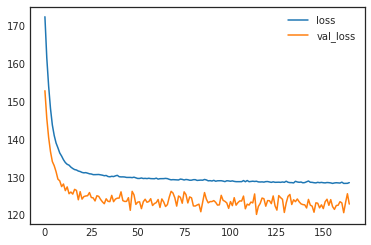

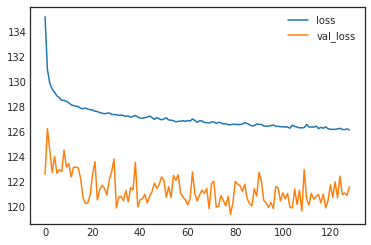

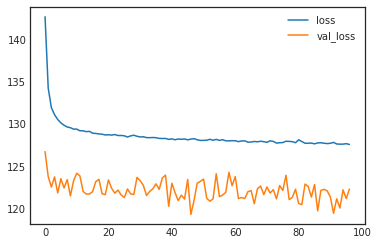

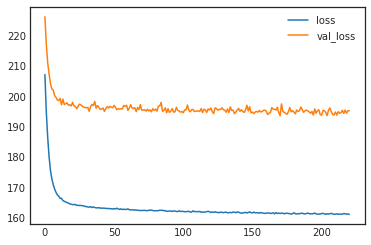

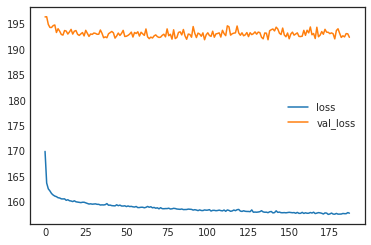

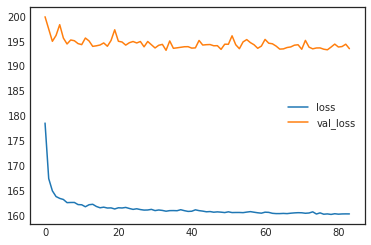

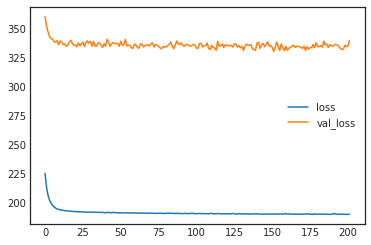

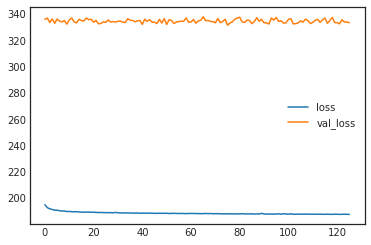

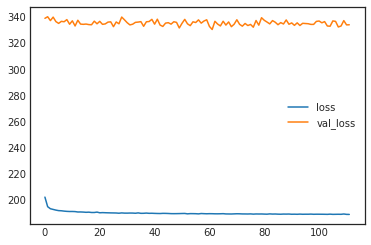

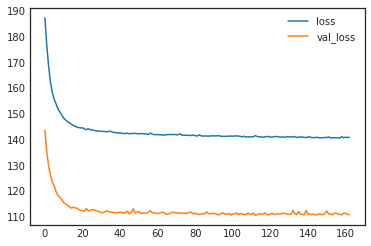

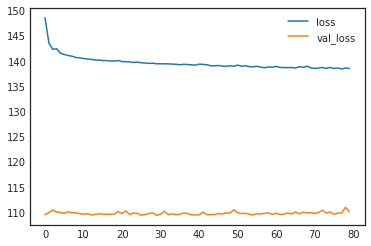

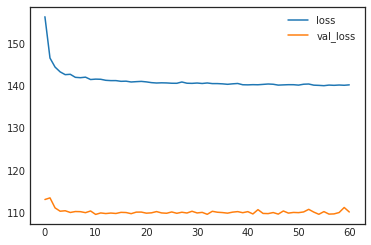

In [119]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [250, 350, 450, 550]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn2_train', 'nn2_val', 'nn2_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test',
                                 'nn6opt_train', 'nn6opt_val', 'nn6opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective_xgb(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgb, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]
    
    ###########
    ### NNs ###
    ###########
    
    neurons_base = 8
    l2_reg_rate = 0.5

    model_snn6 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn6.count_params())

    early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
    optimizer_adam = tf.keras.optimizers.Adam()

    model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
    [r2_score(y_train, model_snn6.predict(X_train)), 
    r2_score(y_val, model_snn6.predict(X_val)),
    r2_score(y_test, model_snn6.predict(X_test))]
    
    
    
    neurons_base = 8
    l2_reg_rate = 0.1

    model_snn2 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn2.count_params())

    model_snn2.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

    time1 = time.time()
    history = model_snn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn2_train':'nn2_test'] = \
    [r2_score(y_train, model_snn2.predict(X_train)), 
    r2_score(y_val, model_snn2.predict(X_val)),
    r2_score(y_test, model_snn2.predict(X_test))]
    
    
    neurons_base = 8
    l2_reg_rate = 0.3

    model_snn4 = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    print(model_snn4.count_params())

    time1 = time.time()
    model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                             batch_size=2048, epochs=1000, verbose=0, callbacks=[early_stopping50])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

    results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
    [r2_score(y_train, model_snn4.predict(X_train)), 
    r2_score(y_val, model_snn4.predict(X_val)),
    r2_score(y_test, model_snn4.predict(X_test))]
    
    
    
    # try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

    time1 = time.time()

    trials = 50

    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective_nn, n_trials=trials)
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    temp = study.best_params
    display(study.best_params, time.time()-time1)

    optimal_hyperpars = list(temp.values())
    display(optimal_hyperpars)
    print(time.time()-time1, optimal_hyperpars)

    optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
    history = optuna_nn.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            batch_size=2048, 
                            epochs=1000,
                            verbose=1, 
                            callbacks=[early_stopping50])

    results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
    [r2_score(y_train, optuna_nn.predict(X_train)), 
    r2_score(y_val, optuna_nn.predict(X_val)),
    r2_score(y_test, optuna_nn.predict(X_test))]
    
    display(results)
    
display(results)

In [120]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      8.526807e-02
xgbf_val        1.858397e-02
xgbf_test       1.596177e-02
xgbgs_train     8.389687e-02
xgbgs_val       5.962121e-02
xgbgs_test      2.173062e-02
xgbo_train      6.345366e-02
xgbo_val        3.752135e-02
xgbo_test       2.081432e-02
nn2_train       7.442289e-02
nn2_val         2.247275e-02
nn2_test        1.507346e-02
nn4_train       6.739575e-02
nn4_val         2.693307e-02
nn4_test        1.588569e-02
nn6_train       7.023660e-02
nn6_val         2.757471e-02
nn6_test        1.518666e-02
nn4opt_train   -4.507291e-06
nn4opt_val     -7.587147e-08
nn4opt_test    -4.336811e-06
nn6opt_train             NaN
nn6opt_val               NaN
nn6opt_test              NaN
dtype: float64

2016.8954348564148


In [121]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.032672,0.035894,0.016715,0.041168,0.01891,0.019674,0.036657,0.024427,0.017811,0.035134,0.025171,0.014855,-0.0,-0.0,-0.000002,NaN,NaN,NaN
3,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.084779,0.055466,0.047675,0.08021,0.026603,0.033315,0.075452,0.033606,0.042676,0.083252,0.032499,0.038525,-0.000001,-0.0,-0.000013,NaN,NaN,NaN


In [122]:
optimal_hyperpars

[1385,
 6,
 0.01909250411368258,
 0.8483465964423721,
 0.5587330649994063,
 2.431455258213158,
 3.5449828419226095,
 0.00041741162073109437,
 0.7711167481571407]

In [123]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [131]:
 
def objective_nn(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]

trials = 50

study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_nn, n_trials=trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display(study.best_params, time.time()-time1)

optimal_hyperpars = list(temp.values())
display(optimal_hyperpars)
print(time.time()-time1, optimal_hyperpars)

optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=1, 
                        callbacks=[early_stopping50])

results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]

[I 2022-09-08 01:56:52,560] A new study created in memory with name: no-name-a8f6010a-9cc9-4bfb-bf28-184cdc3af009


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 176.1862 - mean_squared_error: 149.4071 - val_loss: 132.0486 - val_mean_squared_error: 110.2506
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 166.4893 - mean_squared_error: 148.1045 - val_loss: 125.0695 - val_mean_squared_error: 109.8490
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 160.4892 - mean_squared_error: 147.3976 - val_loss: 120.5728 - val_mean_squared_error: 109.4634
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 156.5760 - mean_squared_error: 146.7641 - val_loss: 117.7276 - val_mean_squared_error: 109.0860
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 153.7962 - mean_squared_error: 145.8768 - val_loss: 115.8001 - val_mean_squared_error: 108.5148
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 151.7149 - mean_squared_error: 144.7278 - val_loss: 114.8202 - val_mean_squared_er

[I 2022-09-08 01:57:17,740] Trial 0 finished with value: 107.72882843017578 and parameters: {'neurons_base': 6, 'l2_regularizer': 0.7303896463634514}. Best is trial 0 with value: 107.72882843017578.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 214.6005 - mean_squared_error: 148.2856 - val_loss: 161.0134 - val_mean_squared_error: 110.0936
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 187.5905 - mean_squared_error: 146.7859 - val_loss: 140.8788 - val_mean_squared_error: 109.3366
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 171.3870 - mean_squared_error: 145.5545 - val_loss: 128.8255 - val_mean_squared_error: 108.0576
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 161.2097 - mean_squared_error: 143.4650 - val_loss: 122.5117 - val_mean_squared_error: 107.3081
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 154.8350 - mean_squared_error: 141.4113 - val_loss: 118.9193 - val_mean_squared_error: 107.2888
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 151.2532 - mean_squared_error: 140.8317 - val_loss: 116.7146 - val_mean_squared_er

[I 2022-09-08 01:57:36,983] Trial 1 finished with value: 108.30110931396484 and parameters: {'neurons_base': 18, 'l2_regularizer': 0.6202174605387506}. Best is trial 0 with value: 107.72882843017578.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 199.6013 - mean_squared_error: 148.0580 - val_loss: 150.1843 - val_mean_squared_error: 109.7197
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 179.5813 - mean_squared_error: 146.5567 - val_loss: 135.2739 - val_mean_squared_error: 108.9988
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 166.8597 - mean_squared_error: 144.8130 - val_loss: 126.0313 - val_mean_squared_error: 107.6739
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 158.6128 - mean_squared_error: 142.5896 - val_loss: 121.2904 - val_mean_squared_error: 107.3972
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 153.7500 - mean_squared_error: 141.4126 - val_loss: 118.2367 - val_mean_squared_error: 107.3337
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 150.5059 - mean_squared_error: 140.6114 - val_loss: 116.1575 - val_mean_squared_er

[I 2022-09-08 01:58:00,454] Trial 2 finished with value: 107.726806640625 and parameters: {'neurons_base': 16, 'l2_regularizer': 0.5239590287311345}. Best is trial 2 with value: 107.726806640625.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 162.3391 - mean_squared_error: 147.7763 - val_loss: 122.1452 - val_mean_squared_error: 109.2113
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 156.6046 - mean_squared_error: 144.7806 - val_loss: 118.4602 - val_mean_squared_error: 107.6426
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 152.2575 - mean_squared_error: 142.0674 - val_loss: 116.8375 - val_mean_squared_error: 107.2275
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 149.5681 - mean_squared_error: 140.4268 - val_loss: 116.3440 - val_mean_squared_error: 107.6985
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 147.9641 - mean_squared_error: 139.7056 - val_loss: 115.5028 - val_mean_squared_error: 107.6435
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 147.0949 - mean_squared_error: 139.5306 - val_loss: 115.0990 - val_mean_squared_er

KeyboardInterrupt: 

In [124]:
# try optuna for NN:

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    display(model.summary())
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2022-09-08 01:05:01,885] A new study created in memory with name: no-name-028dd8a7-95e6-4b99-a345-fdd2ad109154
[W 2022-09-08 01:05:01,895] Trial 0 failed because of the following error: ValueError('This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_17/3767762731.py", line 11, in objective
    display(model.summary())
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2521, in summary
    raise ValueError('This model has not yet been built. '
ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
model_snn.summary()

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster



In [132]:
results

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test,nn6opt_train,nn6opt_val,nn6opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.048607,0.00398,0.018538,0.079078,-0.003591,0.012067,0.072134,0.002932,0.020406,0.073404,0.003463,0.01926,-0.000016,-0.0,-0.000002,NaN,NaN,NaN
1,350,0.102933,0.039992,-0.006382,0.099072,0.070611,-0.005967,0.087757,0.054746,0.00033,0.097236,0.047969,-0.004762,0.085341,0.046768,-0.01735,0.089156,0.049166,-0.011893,-0.000001,-0.0,-0.0,NaN,NaN,NaN
2,450,0.052144,0.015028,0.015156,0.028579,0.034526,0.014994,0.032672,0.035894,0.016715,0.041168,0.01891,0.019674,0.036657,0.024427,0.017811,0.035134,0.025171,0.014855,-0.0,-0.0,-0.000002,NaN,NaN,NaN
3,550,0.097921,0.031527,0.039818,0.147241,0.10085,0.052657,0.084779,0.055466,0.047675,0.08021,0.026603,0.033315,0.075452,0.033606,0.042676,0.083252,0.032499,0.038525,-0.000001,-0.0,-0.000013,NaN,NaN,NaN
